In [2]:
from os import listdir
from os.path import isfile, join
import sys
import copy
import re
import numpy as np

from scipy.signal import stft
import scipy.io as sio
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import csv

from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from tqdm import tqdm
from utils import Person, simple_low_pass, exp_feat, window_spikes, analyze, do_tc_full
import pickle as pkl
import peakutils
import pywt

from jAER_utils.converter import aedat2numpy
from utils import analyze

import pandas as pd
import seaborn as sns
import cv2
from sklearn.feature_extraction.image import extract_patches_2d

In [3]:
# general stuff
fs = 200  # sampling frequency of MYO
VERBOSE = True
data_dir = '/Users/enea/Dropbox/Capocaccia2019_Gesture_DVS_Myo/Dataset/'
classes = classes = ['pinky', 'elle', 'yo', 'index', 'thumb']
classes_dict = {'pinky': 0, 'elle': 1, 'yo': 2, 'index': 3, 'thumb': 4}
classes_inv = {v: k for k, v in classes_dict.items()}

Load all data into subject obects 

In [ ]:
subjects = {}
names = [name for name in listdir(data_dir) if "emg" in name]
for name in names:
    _emg = np.load(data_dir + '{}'.format(name)).astype('float32')
    _ann = np.concatenate([np.array(['none']), np.load(data_dir + '{}'.format(name.replace("emg","ann")))[:-1]])
    
    subjects[name.split("_")[1]] = Person(name.split("_")[1], _emg, _ann, classes=classes)
    
    if VERBOSE:
        print("Loaded {}: EMG = [{}] // ANN = [{}]".format(name.split("_")[1], _emg.shape, len(_ann)))
print("Data Loaded! {} Sessions".format(len(subjects.keys())))

In [ ]:
# separates data in correct trial type
for name, data in subjects.items():
    for _class in classes:
        _annotation = np.float32(data.ann == _class)
        derivative = np.diff(_annotation)/1.0
        begins = np.where(derivative == 1)[0]
        ends = np.where(derivative == -1)[0]
        for b, e in zip(begins, ends):
            _trials = data.emg[b:e]
            data.trials[_class].append(_trials)
            data.begs[_class].append(b)
            data.ends[_class].append(e)
print("Done sorting trials!")

Now every subject has different fields, each field is a dictionary and the keys are the gestures.
We have the following fields: begs (beginning time of trials), ends (end time of trials), trials (actual myo data)

In [ ]:
# example, see that each gesture is 2 seconds
print(np.array(subjects['Gemma1'].begs['elle']) / fs)
print(np.array(subjects['Gemma1'].ends['elle']) / fs)

In [6]:
# this is to find the zero timestepping of the davis
def find_trigger(ts):
    return np.where(np.diff(ts) < 0)[0][0]

def create_frame(x, y, dim=(128, 128)):
    img = np.zeros(dim)
    for _x, _y in zip(x.astype('int32'), y.astype('int32')):
        img[dim[0] - 1 - _x,_y] += 1
    return np.log10(img / np.max(img) + 1e-10)

In [ ]:
subject = 'Bruno2'
# decoders takes some time since it is a very long recordings, especially with DAVIS
events = aedat2numpy(data_dir + subject +'_dvs.aedat')
events = events[:, find_trigger(events[2]):]
events[2] = events[2] / 1e3
print(events.shape)

In [ ]:
gesture = 'thumb'
trial = 3
# load beginning and end 
b = np.array(subjects[subject].begs[gesture][trial]) / fs
e = np.array(subjects[subject].ends[gesture][trial]) / fs

frame_size = 1.
shift = 1.
beginning = b + shift
ending = beginning + frame_size
# slice
sl = (events[2] > beginning) & (events[2] < ending)

img = events[:, sl]
print(img.shape)
fig, ax = plt.subplots(1, 2, figsize=(20,10))

beg_int = int(shift * fs)
end_int = int((shift + frame_size) * fs)

# dd = subjects[subject].trials[gesture][trial][beg_int:end_int]
# feat = analyze(dd, frame_len=0.01, frame_step=0.005, feat='RMS')
# for i in range(8):
#     _ = ax[1].plot(dd[:, i], label='channel{}'.format(i))
# ax[1].legend()

sll = (img[1] > 20) & (img[1] < 110) & (img[0] > 20) & (img[0] < 110)

frame = np.uint8(create_frame(img[1][sll], img[0][sll]) * 254)
blurred = cv2.GaussianBlur(frame, (5, 5), 0)
thresh = cv2.threshold(blurred, 60, 255, cv2.THRESH_BINARY)[1]

M = cv2.moments(thresh)
x = int(M["m10"] / M["m00"])
y = int(M["m01"] / M["m00"])

_ = ax[0].imshow(frame)
ax[0].plot([x - 30, x + 30, x + 30, x - 30, x - 30], 
           [y  - 30, y  - 30, y + 30, y  + 30, y  - 30], '--', linewidth=7)

_ = ax[1].imshow(frame[y - 30: y + 30, x-30:x+30])



In [ ]:
a = (img[0] > (x - 30)) & (img[0] < (x + 30))
b = (img[1] > (127 - y - 30)) & (img[1] < (127 - y + 30))
xx = img[0][a & b]
yy = img[1][a & b]
ts = img[2][a & b]
pol = img[3][a & b]

plt.plot(xx, yy, '.')

In [ ]:
for subject, data in subjects.items():

    # decoders takes some time since it is a very long recordings, especially with DAVIS
    events = aedat2numpy(data_dir + subject +'_dvs.aedat')
    events = events[:, find_trigger(events[2]):]
    events[2] = events[2] / 1e3
    
    for gesture in classes:
        for trial in range(5):
            print("{} :: {} :: {}".format(subject, gesture, trial))
            # load beginning and end 
            b = np.array(data.begs[gesture][trial]) / fs
            e = np.array(data.ends[gesture][trial]) / fs

            frame_size = 2
            shift = 0.
            beginning = b + shift
            ending = beginning + frame_size

            # slice
            sl = (events[2] > beginning) & (events[2] < ending)

            img = events[:, sl]

            beg_int = int(shift * fs)
            end_int = int((shift + frame_size) * fs)

            sll = (img[1] > 20) & (img[1] < 110) & (img[0] > 20) & (img[0] < 110)

            frame = np.uint8(create_frame(img[1][sll], img[0][sll]) * 254)
            blurred = cv2.GaussianBlur(frame, (5, 5), 0)
            thresh = cv2.threshold(blurred, 60, 255, cv2.THRESH_BINARY)[1]

            M = cv2.moments(thresh)
            x = int(M["m10"] / M["m00"])
            y = int(M["m01"] / M["m00"])

            a = (img[0] > (x - 30)) & (img[0] < (x + 30))
            b = (img[1] > (127 - y - 30)) & (img[1] < (127 - y + 30))
            xx = img[0][a & b]
            yy = img[1][a & b]
            ts = img[2][a & b]
            pol = img[3][a & b]

            data.x[gesture].append(xx - min(xx))
            data.y[gesture].append(yy - min(yy))
            data.ts[gesture].append(ts - min(ts))
            data.pol[gesture].append(pol)


In [ ]:
pkl.dump(subjects, open('10_people_dvs_emg.pkl', 'wb'))

In [4]:
data = pkl.load(open('10_people_dvs_emg.pkl', 'rb'))

In [ ]:
sub = 'Melika2'
trial = 1
gesture = 'index'
_x = data[sub].y[gesture][trial]
_y = data[sub].x[gesture][trial]
_ts = data[sub].ts[gesture][trial]
_p = data[sub].pol[gesture][trial]

fil = (_ts > 0.25) & (_ts < 1)
frame = create_frame(_x[fil], _y[fil], dim=(60, 60))
plt.imshow(frame)
plt.figure()
_ = plt.plot(data[sub].trials[gesture][trial])


frame = np.uint8(frame * 254)
blurred = cv2.GaussianBlur(frame, (5, 5), 0)
thresh = cv2.threshold(blurred, 60, 255, cv2.THRESH_BINARY)[1]

sift = cv2.xfeatures2d.SIFT_create()
(kps, descs) = sift.detectAndCompute(thresh, None)

print("# kps: {}, descriptors: {}".format(len(kps), descs.shape))

surf = cv2.xfeatures2d.SURF_create()
(kps, descs) = surf.detectAndCompute(thresh, None)
print("# kps: {}, descriptors: {}".format(len(kps), descs.shape))

In [ ]:
# extract sift and surf 
for subject, sub in data.items():
    for gesture in classes:
        for trial in range(5):

            _x = sub.y[gesture][trial]
            _y = sub.x[gesture][trial]
            _ts = sub.ts[gesture][trial]
            _p = sub.pol[gesture][trial]

            fil = (_ts > 0.200) & (_ts < 2)
            frame = create_frame(_x[fil], _y[fil], dim=(60, 60))

            frame = np.uint8(frame * 254)
            blurred = cv2.GaussianBlur(frame, (5, 5), 0)
            thresh = cv2.threshold(blurred, 60, 255, cv2.THRESH_BINARY)[1]

            sift = cv2.xfeatures2d.SIFT_create()
            (kps, descs1) = sift.detectAndCompute(thresh, None)
            sub.sift[gesture].append(descs1)

            surf = cv2.xfeatures2d.SURF_create()
            (kps, descs2) = surf.detectAndCompute(thresh, None)
            sub.surf[gesture].append(descs2)
            
            print("{}::{}::{}::{}::{}".format(subject, gesture, trial, descs1.shape, descs2.shape))

In [ ]:
X1 = []
X2 = []
Y = []

for subject, sub in data.items():
    for gesture in classes:
        for trial in range(5):
            if sub.sift[gesture][trial].shape[0] >= 7 and sub.surf[gesture][trial].shape[0] >= 7: 
                X1.append(sub.sift[gesture][trial][:7])
                X2.append(sub.surf[gesture][trial][:7])
                Y.append(classes_dict[gesture])
            

X1 = np.array(X1)
X2 = np.array(X2)
X = np.hstack([X1.reshape(X1.shape[0], -1), X2.reshape(X1.shape[0], -1)])
Y = np.array(Y)

X -= np.mean(X, 0, keepdims=True)
X /= np.std(X, 0, keepdims=True) + 1e-15

print(np.array(X1).shape)
print(np.array(X2).shape)
print(np.array(Y).shape)


In [ ]:
print(do_tc_full(X, Y.reshape(-1,1 ), pca_comp=4, avg=True))

In [7]:
# extract sift and surf 

X1 = []
X2 = []
Y = []

for subject, sub in data.items():
    if subject not in ['Enea3', 'Melika2']:
        for gesture in classes:
            for trial in range(5):

                _emg = sub.trials[gesture][trial]

                if _emg.shape[0] < 400:
                    _emg = np.vstack([_emg, np.zeros((400 - _emg.shape[0], 8))])
                _emg = _emg[80:400]
                X2.append(_emg.reshape(-1, 40, 8))

                _x = sub.y[gesture][trial]
                _y = sub.x[gesture][trial]
                _ts = sub.ts[gesture][trial]
                _p = sub.pol[gesture][trial]
                for i in [0.4, 0.6, 0.8, 1., 1.2, 1.4, 1.6, 1.8]:
                    fil = (_ts > i) & (_ts < i + .2)
                    frame = create_frame(_x[fil], _y[fil], dim=(60, 60))
                    X1.append(frame)
                    Y.append(classes_dict[gesture])
#                     print("{}::{}::{}::{}::{}".format(subject, gesture, trial, frame.shape, i))

In [7]:
X1 = np.array(X1)
X2 = np.array(X2).reshape(-1, 40, 8)
Y = np.array(Y).reshape(-1, 1)

print(np.array(X1).shape)
print(np.array(X2).shape)
print(np.array(Y).shape)

# np.save('_cc19_hand_gestures_10p_img', X1)
# np.save('_cc19_hand_gestures_10p_emg', X2)
# np.save('_cc19_hand_gestures_10p_lbl', Y)

(5600, 60, 60)
(5600, 40, 8)
(5600, 1)


In [ ]:
print((X1[0] - np.min(X1[0]))

In [ ]:
fig, ax = plt.subplots(10, 10, figsize=(20, 20))

for i in range(10):
    for j in range(10):
        _idx = np.random.randint(5600)
        a = X1[_idx]
        a -= np.min(a)
        a /= np.max(a)
        frame = np.uint8(a * 255)
        blurred = cv2.GaussianBlur(frame, (5, 5), 0)
        thresh = cv2.threshold(blurred, 60, 255, cv2.THRESH_BINARY)[1]
        ax[i][j].imshow(frame)
        ax[i][j].set_title(classes_inv[Y[_idx][0]])

36


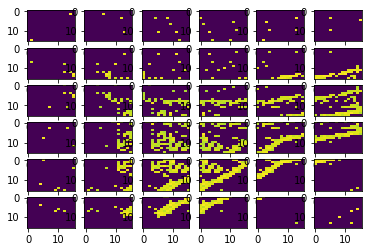

In [127]:
def extract_grid(img, size=(20, 20), shift=None):
    if shift == None:
        shift = size
    x, y = img.shape
    patches = []
    n_win_x = (x - size[0]) // shift[0] + 1
    n_win_y = (y - size[1]) // shift[1] + 1
    for i in range(n_win_x):
        for j in range(n_win_y):
            patches.append(img[i * shift[0]:i * shift[0] + size[0], j * shift[1]:j * shift[1] + size[1]])
            
    return patches

pp = extract_grid(X1[100], (16, 16), shift=(8, 8))
print(len(pp))
fig, ax = plt.subplots(6, 6)
for i, ppp in enumerate(pp):
    ax[i//6][i % 6].imshow(ppp, aspect='auto')

In [12]:
# SIFT features codebook
all_V_sift = []
all_patches = []
sift = cv2.xfeatures2d.SIFT_create()

for j, img in enumerate(X1):
    a = img
    a -= np.min(a)
    a /= np.max(a)
    frame = np.uint8(a * 255)
    
    patches = extract_patches_2d(frame, (20, 20), max_patches=0.1)

    print("{}::{}/{}".format(len(patches), j, len(X1)))
    _patches = []
    for p in patches:
        
        (kps, descs1) = sift.detectAndCompute(p, None)
        if descs1 is not None:
            _patches.append(descs1)
    all_V_sift.append(_patches)
    
for_kmeans = np.vstack([np.vstack(i) for i in all_V_sift])
print(for_kmeans.shape)

168::0/5600
168::1/5600
168::2/5600
168::3/5600
168::4/5600
168::5/5600
168::6/5600
168::7/5600
168::8/5600
168::9/5600
168::10/5600
168::11/5600
168::12/5600
168::13/5600
168::14/5600
168::15/5600
168::16/5600
168::17/5600
168::18/5600
168::19/5600
168::20/5600
168::21/5600
168::22/5600
168::23/5600
168::24/5600
168::25/5600
168::26/5600
168::27/5600
168::28/5600
168::29/5600
168::30/5600
168::31/5600
168::32/5600
168::33/5600
168::34/5600
168::35/5600
168::36/5600
168::37/5600
168::38/5600
168::39/5600
168::40/5600
168::41/5600
168::42/5600
168::43/5600
168::44/5600
168::45/5600
168::46/5600
168::47/5600
168::48/5600
168::49/5600
168::50/5600
168::51/5600
168::52/5600
168::53/5600
168::54/5600
168::55/5600
168::56/5600
168::57/5600
168::58/5600
168::59/5600
168::60/5600
168::61/5600
168::62/5600
168::63/5600
168::64/5600
168::65/5600
168::66/5600
168::67/5600
168::68/5600
168::69/5600
168::70/5600
168::71/5600
168::72/5600
168::73/5600
168::74/5600
168::75/5600
168::76/5600
168::77/5

168::596/5600
168::597/5600
168::598/5600
168::599/5600
168::600/5600
168::601/5600
168::602/5600
168::603/5600
168::604/5600
168::605/5600
168::606/5600
168::607/5600
168::608/5600
168::609/5600
168::610/5600
168::611/5600
168::612/5600
168::613/5600
168::614/5600
168::615/5600
168::616/5600
168::617/5600
168::618/5600
168::619/5600
168::620/5600
168::621/5600
168::622/5600
168::623/5600
168::624/5600
168::625/5600
168::626/5600
168::627/5600
168::628/5600
168::629/5600
168::630/5600
168::631/5600
168::632/5600
168::633/5600
168::634/5600
168::635/5600
168::636/5600
168::637/5600
168::638/5600
168::639/5600
168::640/5600
168::641/5600
168::642/5600
168::643/5600
168::644/5600
168::645/5600
168::646/5600
168::647/5600
168::648/5600
168::649/5600
168::650/5600
168::651/5600
168::652/5600
168::653/5600
168::654/5600
168::655/5600
168::656/5600
168::657/5600
168::658/5600
168::659/5600
168::660/5600
168::661/5600
168::662/5600
168::663/5600
168::664/5600
168::665/5600
168::666/5600
168::6

168::1171/5600
168::1172/5600
168::1173/5600
168::1174/5600
168::1175/5600
168::1176/5600
168::1177/5600
168::1178/5600
168::1179/5600
168::1180/5600
168::1181/5600
168::1182/5600
168::1183/5600
168::1184/5600
168::1185/5600
168::1186/5600
168::1187/5600
168::1188/5600
168::1189/5600
168::1190/5600
168::1191/5600
168::1192/5600
168::1193/5600
168::1194/5600
168::1195/5600
168::1196/5600
168::1197/5600
168::1198/5600
168::1199/5600
168::1200/5600
168::1201/5600
168::1202/5600
168::1203/5600
168::1204/5600
168::1205/5600
168::1206/5600
168::1207/5600
168::1208/5600
168::1209/5600
168::1210/5600
168::1211/5600
168::1212/5600
168::1213/5600
168::1214/5600
168::1215/5600
168::1216/5600
168::1217/5600
168::1218/5600
168::1219/5600
168::1220/5600
168::1221/5600
168::1222/5600
168::1223/5600
168::1224/5600
168::1225/5600
168::1226/5600
168::1227/5600
168::1228/5600
168::1229/5600
168::1230/5600
168::1231/5600
168::1232/5600
168::1233/5600
168::1234/5600
168::1235/5600
168::1236/5600
168::1237/

168::1721/5600
168::1722/5600
168::1723/5600
168::1724/5600
168::1725/5600
168::1726/5600
168::1727/5600
168::1728/5600
168::1729/5600
168::1730/5600
168::1731/5600
168::1732/5600
168::1733/5600
168::1734/5600
168::1735/5600
168::1736/5600
168::1737/5600
168::1738/5600
168::1739/5600
168::1740/5600
168::1741/5600
168::1742/5600
168::1743/5600
168::1744/5600
168::1745/5600
168::1746/5600
168::1747/5600
168::1748/5600
168::1749/5600
168::1750/5600
168::1751/5600
168::1752/5600
168::1753/5600
168::1754/5600
168::1755/5600
168::1756/5600
168::1757/5600
168::1758/5600
168::1759/5600
168::1760/5600
168::1761/5600
168::1762/5600
168::1763/5600
168::1764/5600
168::1765/5600
168::1766/5600
168::1767/5600
168::1768/5600
168::1769/5600
168::1770/5600
168::1771/5600
168::1772/5600
168::1773/5600
168::1774/5600
168::1775/5600
168::1776/5600
168::1777/5600
168::1778/5600
168::1779/5600
168::1780/5600
168::1781/5600
168::1782/5600
168::1783/5600
168::1784/5600
168::1785/5600
168::1786/5600
168::1787/

168::2271/5600
168::2272/5600
168::2273/5600
168::2274/5600
168::2275/5600
168::2276/5600
168::2277/5600
168::2278/5600
168::2279/5600
168::2280/5600
168::2281/5600
168::2282/5600
168::2283/5600
168::2284/5600
168::2285/5600
168::2286/5600
168::2287/5600
168::2288/5600
168::2289/5600
168::2290/5600
168::2291/5600
168::2292/5600
168::2293/5600
168::2294/5600
168::2295/5600
168::2296/5600
168::2297/5600
168::2298/5600
168::2299/5600
168::2300/5600
168::2301/5600
168::2302/5600
168::2303/5600
168::2304/5600
168::2305/5600
168::2306/5600
168::2307/5600
168::2308/5600
168::2309/5600
168::2310/5600
168::2311/5600
168::2312/5600
168::2313/5600
168::2314/5600
168::2315/5600
168::2316/5600
168::2317/5600
168::2318/5600
168::2319/5600
168::2320/5600
168::2321/5600
168::2322/5600
168::2323/5600
168::2324/5600
168::2325/5600
168::2326/5600
168::2327/5600
168::2328/5600
168::2329/5600
168::2330/5600
168::2331/5600
168::2332/5600
168::2333/5600
168::2334/5600
168::2335/5600
168::2336/5600
168::2337/

168::2821/5600
168::2822/5600
168::2823/5600
168::2824/5600
168::2825/5600
168::2826/5600
168::2827/5600
168::2828/5600
168::2829/5600
168::2830/5600
168::2831/5600
168::2832/5600
168::2833/5600
168::2834/5600
168::2835/5600
168::2836/5600
168::2837/5600
168::2838/5600
168::2839/5600
168::2840/5600
168::2841/5600
168::2842/5600
168::2843/5600
168::2844/5600
168::2845/5600
168::2846/5600
168::2847/5600
168::2848/5600
168::2849/5600
168::2850/5600
168::2851/5600
168::2852/5600
168::2853/5600
168::2854/5600
168::2855/5600
168::2856/5600
168::2857/5600
168::2858/5600
168::2859/5600
168::2860/5600
168::2861/5600
168::2862/5600
168::2863/5600
168::2864/5600
168::2865/5600
168::2866/5600
168::2867/5600
168::2868/5600
168::2869/5600
168::2870/5600
168::2871/5600
168::2872/5600
168::2873/5600
168::2874/5600
168::2875/5600
168::2876/5600
168::2877/5600
168::2878/5600
168::2879/5600
168::2880/5600
168::2881/5600
168::2882/5600
168::2883/5600
168::2884/5600
168::2885/5600
168::2886/5600
168::2887/

168::3370/5600
168::3371/5600
168::3372/5600
168::3373/5600
168::3374/5600
168::3375/5600
168::3376/5600
168::3377/5600
168::3378/5600
168::3379/5600
168::3380/5600
168::3381/5600
168::3382/5600
168::3383/5600
168::3384/5600
168::3385/5600
168::3386/5600
168::3387/5600
168::3388/5600
168::3389/5600
168::3390/5600
168::3391/5600
168::3392/5600
168::3393/5600
168::3394/5600
168::3395/5600
168::3396/5600
168::3397/5600
168::3398/5600
168::3399/5600
168::3400/5600
168::3401/5600
168::3402/5600
168::3403/5600
168::3404/5600
168::3405/5600
168::3406/5600
168::3407/5600
168::3408/5600
168::3409/5600
168::3410/5600
168::3411/5600
168::3412/5600
168::3413/5600
168::3414/5600
168::3415/5600
168::3416/5600
168::3417/5600
168::3418/5600
168::3419/5600
168::3420/5600
168::3421/5600
168::3422/5600
168::3423/5600
168::3424/5600
168::3425/5600
168::3426/5600
168::3427/5600
168::3428/5600
168::3429/5600
168::3430/5600
168::3431/5600
168::3432/5600
168::3433/5600
168::3434/5600
168::3435/5600
168::3436/

168::3920/5600
168::3921/5600
168::3922/5600
168::3923/5600
168::3924/5600
168::3925/5600
168::3926/5600
168::3927/5600
168::3928/5600
168::3929/5600
168::3930/5600
168::3931/5600
168::3932/5600
168::3933/5600
168::3934/5600
168::3935/5600
168::3936/5600
168::3937/5600
168::3938/5600
168::3939/5600
168::3940/5600
168::3941/5600
168::3942/5600
168::3943/5600
168::3944/5600
168::3945/5600
168::3946/5600
168::3947/5600
168::3948/5600
168::3949/5600
168::3950/5600
168::3951/5600
168::3952/5600
168::3953/5600
168::3954/5600
168::3955/5600
168::3956/5600
168::3957/5600
168::3958/5600
168::3959/5600
168::3960/5600
168::3961/5600
168::3962/5600
168::3963/5600
168::3964/5600
168::3965/5600
168::3966/5600
168::3967/5600
168::3968/5600
168::3969/5600
168::3970/5600
168::3971/5600
168::3972/5600
168::3973/5600
168::3974/5600
168::3975/5600
168::3976/5600
168::3977/5600
168::3978/5600
168::3979/5600
168::3980/5600
168::3981/5600
168::3982/5600
168::3983/5600
168::3984/5600
168::3985/5600
168::3986/

168::4469/5600
168::4470/5600
168::4471/5600
168::4472/5600
168::4473/5600
168::4474/5600
168::4475/5600
168::4476/5600
168::4477/5600
168::4478/5600
168::4479/5600
168::4480/5600
168::4481/5600
168::4482/5600
168::4483/5600
168::4484/5600
168::4485/5600
168::4486/5600
168::4487/5600
168::4488/5600
168::4489/5600
168::4490/5600
168::4491/5600
168::4492/5600
168::4493/5600
168::4494/5600
168::4495/5600
168::4496/5600
168::4497/5600
168::4498/5600
168::4499/5600
168::4500/5600
168::4501/5600
168::4502/5600
168::4503/5600
168::4504/5600
168::4505/5600
168::4506/5600
168::4507/5600
168::4508/5600
168::4509/5600
168::4510/5600
168::4511/5600
168::4512/5600
168::4513/5600
168::4514/5600
168::4515/5600
168::4516/5600
168::4517/5600
168::4518/5600
168::4519/5600
168::4520/5600
168::4521/5600
168::4522/5600
168::4523/5600
168::4524/5600
168::4525/5600
168::4526/5600
168::4527/5600
168::4528/5600
168::4529/5600
168::4530/5600
168::4531/5600
168::4532/5600
168::4533/5600
168::4534/5600
168::4535/

168::5017/5600
168::5018/5600
168::5019/5600
168::5020/5600
168::5021/5600
168::5022/5600
168::5023/5600
168::5024/5600
168::5025/5600
168::5026/5600
168::5027/5600
168::5028/5600
168::5029/5600
168::5030/5600
168::5031/5600
168::5032/5600
168::5033/5600
168::5034/5600
168::5035/5600
168::5036/5600
168::5037/5600
168::5038/5600
168::5039/5600
168::5040/5600
168::5041/5600
168::5042/5600
168::5043/5600
168::5044/5600
168::5045/5600
168::5046/5600
168::5047/5600
168::5048/5600
168::5049/5600
168::5050/5600
168::5051/5600
168::5052/5600
168::5053/5600
168::5054/5600
168::5055/5600
168::5056/5600
168::5057/5600
168::5058/5600
168::5059/5600
168::5060/5600
168::5061/5600
168::5062/5600
168::5063/5600
168::5064/5600
168::5065/5600
168::5066/5600
168::5067/5600
168::5068/5600
168::5069/5600
168::5070/5600
168::5071/5600
168::5072/5600
168::5073/5600
168::5074/5600
168::5075/5600
168::5076/5600
168::5077/5600
168::5078/5600
168::5079/5600
168::5080/5600
168::5081/5600
168::5082/5600
168::5083/

168::5567/5600
168::5568/5600
168::5569/5600
168::5570/5600
168::5571/5600
168::5572/5600
168::5573/5600
168::5574/5600
168::5575/5600
168::5576/5600
168::5577/5600
168::5578/5600
168::5579/5600
168::5580/5600
168::5581/5600
168::5582/5600
168::5583/5600
168::5584/5600
168::5585/5600
168::5586/5600
168::5587/5600
168::5588/5600
168::5589/5600
168::5590/5600
168::5591/5600
168::5592/5600
168::5593/5600
168::5594/5600
168::5595/5600
168::5596/5600
168::5597/5600
168::5598/5600
168::5599/5600
(1963170, 128)


In [ ]:
np.array(all_V_sift[0][0]).shape

In [9]:
for_kmeans = np.vstack([np.vstack(i) for i in all_V_sift])
print(for_kmeans.shape)

(9792395, 128)


In [13]:
np.save('kepoints_20x20_168_sift', for_kmeans)

In [15]:
for_kmeans = np.load('kepoints_20x20_168_sift.npy')
print(for_kmeans.shape)

(1963170, 128)


In [16]:
# kmeans
from sklearn.cluster import KMeans
k = 500
kmeans = KMeans(n_clusters=k, random_state=0).fit(for_kmeans[::5])
C_sift = kmeans.cluster_centers_
print(C_sift.shape)

KeyboardInterrupt: 

In [10]:
np.save('centers_20x20_840_sift', C_sift)

In [11]:
# create histogram features
all_h_sift = []

for feat in enumerate(all_V_sift):
    
    h = np.zeros((k,))
    
    for p in feat:
        _id = np.argmin(np.linalg.norm(p - C_sift, axis=1))
        h[_id] += 1
                
    all_h_sift.append(h)

    
all_h_sift = np.array(all_h_sift)
print(all_h_sift.shape)


(0,)


In [ ]:
# create histogram features
all_h_sift = []
sift = cv2.xfeatures2d.SIFT_create()

for j, img in enumerate(X1):
    a = img
    a -= np.min(a)
    a /= np.max(a)
    frame = np.uint8(a * 255)

    patches = extract_grid(frame)
    h = np.zeros((k,))
    
    for p in patches:
        (kps, descs1) = sift.detectAndCompute(p, None)
        
        if descs1 is not None:
            for d in descs1:
                _id = np.argmin(np.linalg.norm(d - C_sift, axis=1))
                h[_id] += 1
                
    all_h_sift.append(h)

    
all_h_sift = np.array(all_h_sift)
print(all_h_sift.shape)


In [ ]:
print(all_h_sift[0])

In [ ]:
_XX = np.array([i / np.linalg.norm(i) for i in all_h_sift])

print(do_tc_full(_XX, Y, avg=True, verbose=True))

0.1867100736530828
(60, 60)


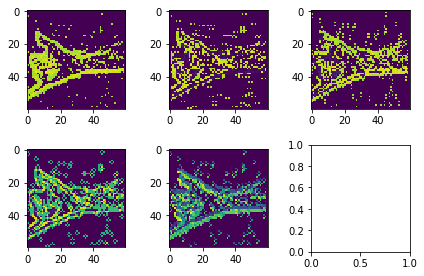

In [103]:
im = X1[2113]
im -= np.min(im)
im /= np.max(im)
print(im.mean())
fig, ax = plt.subplots(2, 3)
ax[0][0].imshow(im)

im = np.float32(im)
 
# Calculate gradient 
gx = cv2.Sobel(im, cv2.CV_32F, 1, 0, ksize=1)
gy = cv2.Sobel(im, cv2.CV_32F, 0, 1, ksize=1)
print(gy.shape)
ax[0][1].imshow(np.abs(gx))
ax[0][2].imshow(np.abs(gy))

# mag angle
mag, angle = cv2.cartToPolar(gx, gy, angleInDegrees=True)
ax[1][0].imshow(np.abs(mag))
ax[1][1].imshow(angle)
plt.tight_layout()

patches = extract_grid(im, (8, 8))
kk = patches[17]
gx_p = cv2.Sobel(kk, cv2.CV_32F, 1, 0, ksize=1)
gy_p = cv2.Sobel(kk, cv2.CV_32F, 0, 1, ksize=1)

# mag angle
mag_p, angle_p = cv2.cartToPolar(gx_p, gy_p, angleInDegrees=True)
angle_p = np.abs(angle_p - 180)



In [ ]:
N_BUCKETS = 9
CELL_SIZE = 8  # Each cell is 8x8 pixels
BLOCK_SIZE = 2  # Each block is 2x2 cells

def assign_bucket_vals(m, d, bucket_vals):
    left_bin = int(d / 20.) % N_BUCKETS
    # Handle the case when the direction is between [160, 180)
    if (d == 180.):
        right_bin = 0
    else:
        right_bin = (int(d / 20.) + 1) % N_BUCKETS
    
    if left_bin < right_bin:
        left_val= m * (right_bin * 20 - d) / 20
        right_val = m * (d - left_bin * 20) / 20
    else:
        left_val= m * (d - left_bin * 20) / 20
        right_val = m * (right_bin * 20 - d) / 20 
    if left_val < 0:
        left_val = 0.
    if right_val < 0:
        right_val = 0.
    bucket_vals[left_bin] += np.abs(left_val)
    bucket_vals[right_bin] += np.abs(right_val)
    
all_veat = []
for j, im in enumerate(X1):
    im -= np.min(im)
    im /= np.max(im)
    im = np.float32(im)
    blocks = extract_grid(im, (16, 16), (8, 8))

    all_buckets = []
    for block in blocks:
        cells = extract_grid(block, (8, 8))
        to_concat = []
        for cell in cells:
            bucket_vals = np.zeros((N_BUCKETS))
            gx_p = cv2.Sobel(cell, cv2.CV_32F, 1, 0, ksize=1)
            gy_p = cv2.Sobel(cell, cv2.CV_32F, 0, 1, ksize=1)

            # mag angle
            mag_p, angle_p = cv2.cartToPolar(gx_p, gy_p, angleInDegrees=True)
            mag_p = np.abs(mag_p)
            angle_p = np.abs(angle_p - 180)
            for m, d in zip(mag_p.reshape(-1,), angle_p.reshape(-1)):
                assign_bucket_vals(m, d, bucket_vals)
            to_concat.append(bucket_vals)
        veat = np.array(to_concat)
        all_buckets.append(veat)

    veat = np.array(all_buckets)
    all_veat.append(veat)
    print(j)

print(np.array(all_veat)).shape

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269


In [116]:
print(np.array(all_veat).shape)

(5600, 324)


In [120]:
acc_tr, acc_te = do_tc_full(np.array(all_veat), np.array(Y).reshape(-1,1), pca_comp=50, verbose=True, avg=True)

Features: 324 => 50
Train on: 5040 / Test on 560
Fold 0: Train acc: 0.517 || Test acc: 0.484
Fold 1: Train acc: 0.517 || Test acc: 0.487
Fold 2: Train acc: 0.518 || Test acc: 0.47


KeyboardInterrupt: 

In [78]:
# Random location [200, 200] as an example.
loc_x = loc_y = 200

ydata = get_magnitude_hist_block(loc_x, loc_y)
ydata = ydata / np.linalg.norm(ydata)

xdata = range(len(ydata))
bucket_names = np.tile(np.arange(N_BUCKETS), BLOCK_SIZE * BLOCK_SIZE)

assert len(ydata) == N_BUCKETS * (BLOCK_SIZE * BLOCK_SIZE)
assert len(bucket_names) == len(ydata)

plt.figure(figsize=(10, 3))
plt.bar(xdata, ydata, align='center', alpha=0.8, width=0.9)
plt.xticks(xdata, bucket_names * 20, rotation=90)
plt.xlabel('Direction buckets')
plt.ylabel('Magnitude')
plt.grid(ls='--', color='k', alpha=0.1)
plt.title("HOG of block at [%d, %d]" % (loc_x, loc_y))
plt.tight_layout()

NameError: name 'reduce' is not defined

In [48]:
all_hog = []

for img in X1:
    # HOG
    a = img
    a -= np.min(a)
    a /= np.max(a)
    frame = np.uint8(a * 255)

    patches = extract_grid(frame, (8, 8))

    all_hist = []

    for p in patches:
        gx = cv2.Sobel(p, cv2.CV_32F, 1, 0)
        gy = cv2.Sobel(p, cv2.CV_32F, 0, 1)


        mag, ang = cv2.cartToPolar(gx, gy)
        bin_n = 16
        bin = np.int32(bin_n*ang/(2*np.pi))
        bin_cells = bin[:100,:100], bin[100:,:100], bin[:100,100:], bin[100:,100:]
        mag_cells = mag[:100,:100], mag[100:,:100], mag[:100,100:], mag[100:,100:]
        hists = [np.bincount(b.ravel(), m.ravel(), bin_n) for b, m in zip(bin_cells, mag_cells)]
        hist = np.hstack(hists)
        all_hist.append(hist)
    # transform to Hellinger kernel
    hist = sum(all_hist)
    eps = 1e-7
    hist /= hist.sum() + eps
    hist = np.sqrt(hist)
    hist /= np.linalg.norm(hist) + eps

    all_hog.append(hist)
print(np.array(all_hog).shape)

(5600, 64)


In [50]:
acc_tr, acc_te = do_tc_full(np.array(all_hog), np.array(Y).reshape(-1,1), verbose=True, avg=True)

Train on: 5040 / Test on 560
Fold 0: Train acc: 0.202 || Test acc: 0.18
Fold 1: Train acc: 0.204 || Test acc: 0.166
Fold 2: Train acc: 0.202 || Test acc: 0.18
Fold 3: Train acc: 0.203 || Test acc: 0.17
Fold 4: Train acc: 0.262 || Test acc: 0.232
Fold 5: Train acc: 0.202 || Test acc: 0.179
Fold 6: Train acc: 0.204 || Test acc: 0.161
Fold 7: Train acc: 0.203 || Test acc: 0.171
Fold 8: Train acc: 0.202 || Test acc: 0.184
Fold 9: Train acc: 0.203 || Test acc: 0.173


ValueError: too many values to unpack (expected 2)

In [ ]:
all_X, all_Y = [], []
n_ch = 8
preprocess = True
frame_len = 0.3
overlap = 0.0
frame_step = frame_len * (1. - overlap)
features = ['MAV', 'RMS', 'SD']
n_comp = 8
for i, idx in enumerate(X2):
    _sub = np.mean(np.abs(idx), 0)
    all_X.append(_sub)
    all_Y.append(Y[i])

all_X = np.vstack(all_X)
all_Y = np.vstack(all_Y)

all_X -= np.mean(all_X, 0, keepdims=True)
all_X /= np.std(all_X, 0, keepdims=True) + 1e-15

acc_tr, acc_te = do_tc_full(all_X, all_Y, verbose=True, pca_comp=n_comp, avg=False)
print("Train: {:.4} +/- {:.4}".format(np.mean(acc_tr), np.std(acc_tr)))
print("Test: {:.4} +/- {:.4}".format(np.mean(acc_te), np.std(acc_te)))

In [ ]:
sift = cv2.xfeatures2d.SIFT_create()
(kps, descs) = sift.detectAndCompute(frame, None)

print(descs.shape)

In [ ]:
import csv
with open('gesture.csv', 'w') as f:
    csv_writer = csv.writer(f, delimiter=',')
    csv_writer.writerow(['x', 'y', 'type'])
    for i in range(img.shape[1]):
        csv_writer.writerow([img[0, i], img[1, i], img[3, i]])


In [ ]:
data = pd.read_csv('gesture.csv')

g = sns.jointplot("x", "y", data=data, size=20)
plt.savefig('spatial_density_yo.pdf')

In [ ]:
from sklearn.mixture import GaussianMixture
import scipy.stats as stats
gm = GaussianMixture(4) 
gm.fit(img[0].reshape(-1, 1) / 180)

x = np.linspace(0, 1, 1000)
plt.hist(img[0] / 180, 50, density=True)
plt.plot(x.reshape(-1, 1), stats.norm.pdf(x, gm.means_[0], gm.covariances_[0]).T)
plt.plot(x.reshape(-1, 1), stats.norm.pdf(x, gm.means_[1], gm.covariances_[1]).T)
plt.plot(x.reshape(-1, 1), stats.norm.pdf(x, gm.means_[2], gm.covariances_[2]).T)

